In [1]:
import sys
import os

SCRIPT_PATH = os.path.join(os.path.abspath(os.path.dirname('../__file__')), 'script')
sys.path.insert(0, SCRIPT_PATH)


from markov_pyactup import *
from statsmodels.formula.api import logit, glm
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)


main_dir = os.path.dirname(os.path.realpath('../__file__'))
dest_dir = os.path.join(main_dir, 'data', 'model', 'param_effect')

main_dir, dest_dir

if not os.path.exists(dest_dir):
    os.mkdir(dest_dir)
    
# dest_dir = None

Error trying to connect to ACT-R at 127.0.0.1 : 2650 with exception (<class 'ConnectionRefusedError'>, ConnectionRefusedError(61, 'Connection refused'), <traceback object at 0x7fd92786d580>)
ACT-R connection NOT established, but no exception detected or already handled.
Could not start ACT-R connection.


## IBL-MB Model

### Effect of temperature (noise)

...LOAD...


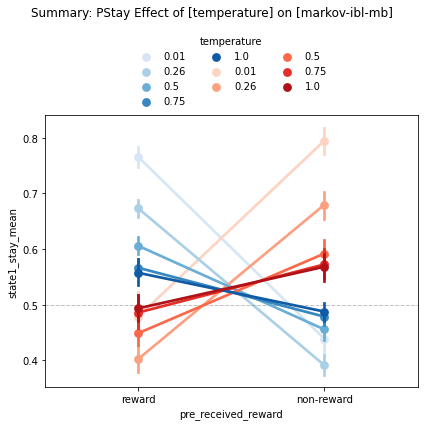

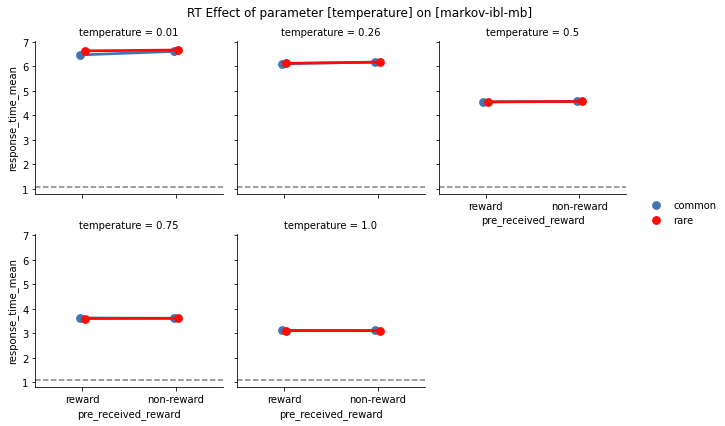

In [2]:
model_name = 'markov-ibl-mb'
param_name = 'temperature'
df = MarkovSimulation.simulate_param_effect(model_name=model_name, param_name=param_name, save_output=dest_dir, e=50)
MarkovPlot.plot_param_effect(df=df, model_name=model_name, param_name=param_name, combination=True)
MarkovPlot.plot_param_effect_rt(df=df, model_name=model_name, param_name=param_name, combination=False)

### Effect of decay

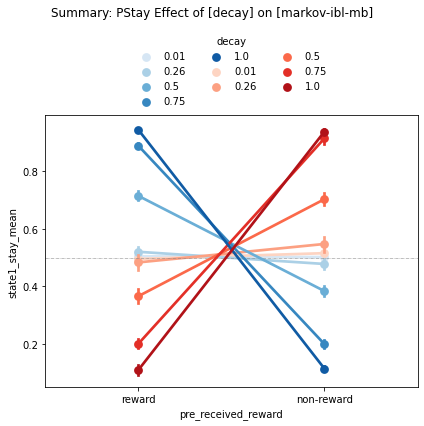

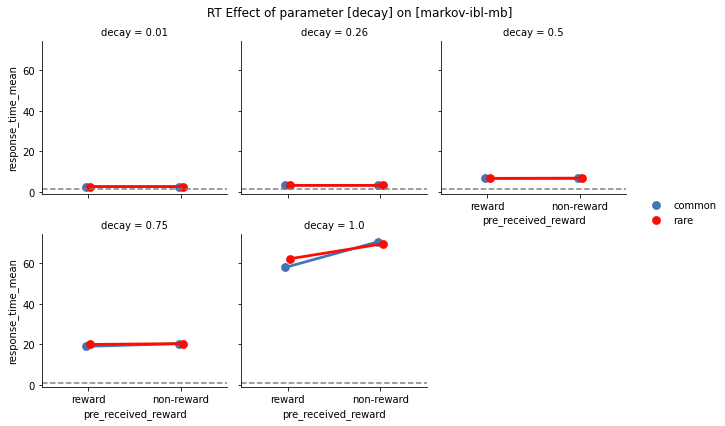

In [3]:
model_name = 'markov-ibl-mb'
param_name = 'decay'
df = MarkovSimulation.simulate_param_effect(model_name=model_name, param_name=param_name, save_output=dest_dir, e=50)
MarkovPlot.plot_param_effect(df=df, model_name=model_name, param_name=param_name, combination=True)
MarkovPlot.plot_param_effect_rt(df=df, model_name=model_name, param_name=param_name, combination=False)

### Effect of lf (latency factor)

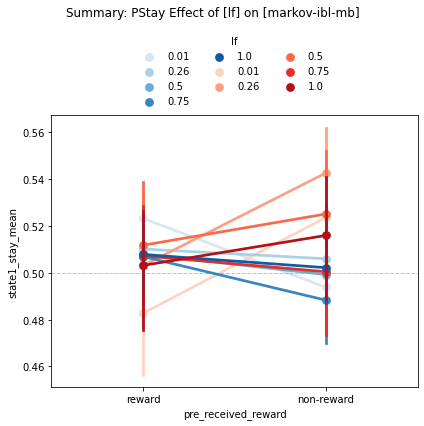

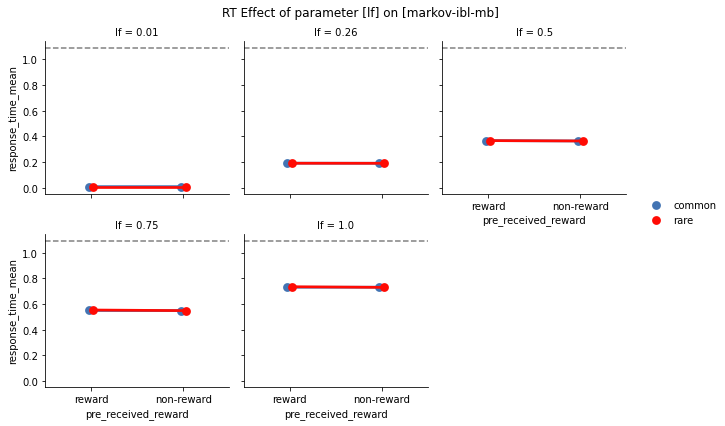

In [4]:
model_name = 'markov-ibl-mb'
param_name = 'lf'
df = MarkovSimulation.simulate_param_effect(model_name=model_name, param_name=param_name, save_output=dest_dir, e=50)
MarkovPlot.plot_param_effect(df=df, model_name=model_name, param_name=param_name, combination=True)
MarkovPlot.plot_param_effect_rt(df=df, model_name=model_name, param_name=param_name, combination=False)

### Effect of fixed_cost

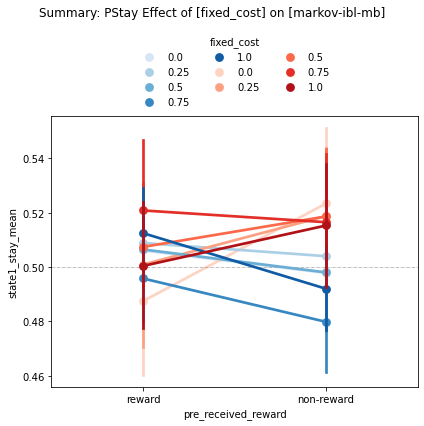

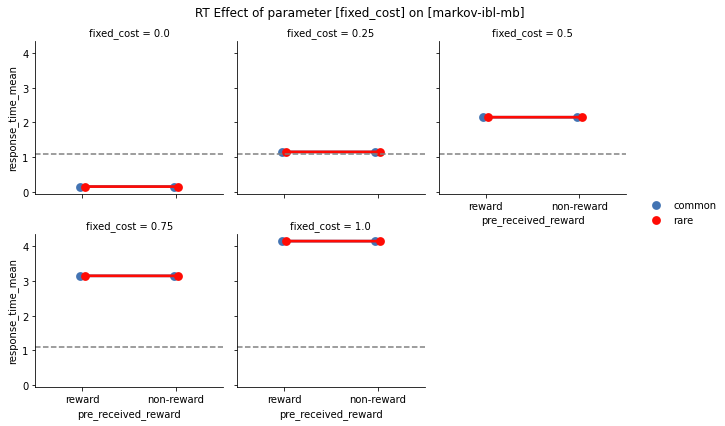

In [5]:
model_name = 'markov-ibl-mb'
param_name = 'fixed_cost'
df = MarkovSimulation.simulate_param_effect(model_name=model_name, param_name=param_name, save_output=dest_dir, e=50)
MarkovPlot.plot_param_effect(df=df, model_name=model_name, param_name=param_name, combination=True)
MarkovPlot.plot_param_effect_rt(df=df, model_name=model_name, param_name=param_name, combination=False)

## IBL-Hybrid Model

### Effect of temperature (noise)

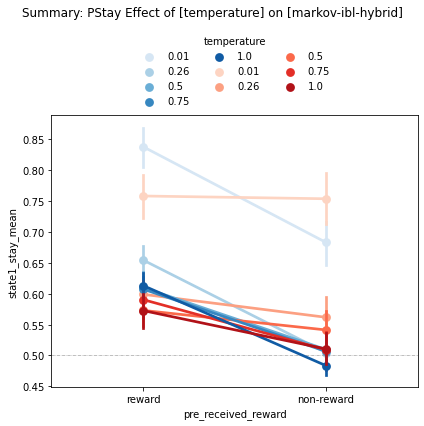

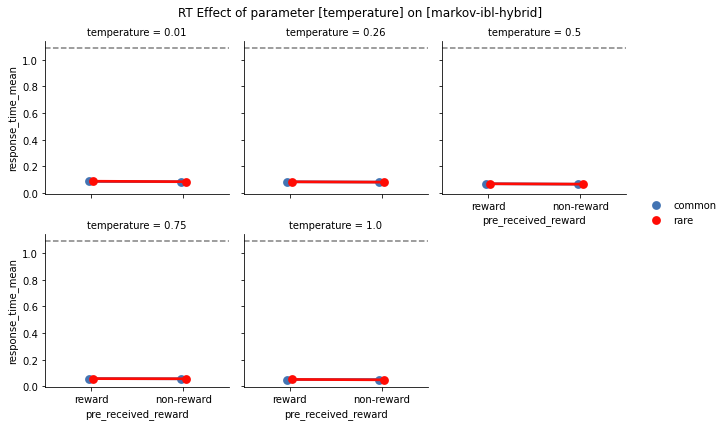

In [6]:
model_name = 'markov-ibl-hybrid'
param_name = 'temperature'
df = MarkovSimulation.simulate_param_effect(model_name=model_name, param_name=param_name, save_output=dest_dir, e=50)
MarkovPlot.plot_param_effect(df=df, model_name=model_name, param_name=param_name, combination=True)
MarkovPlot.plot_param_effect_rt(df=df, model_name=model_name, param_name=param_name, combination=False)

### Effect of decay

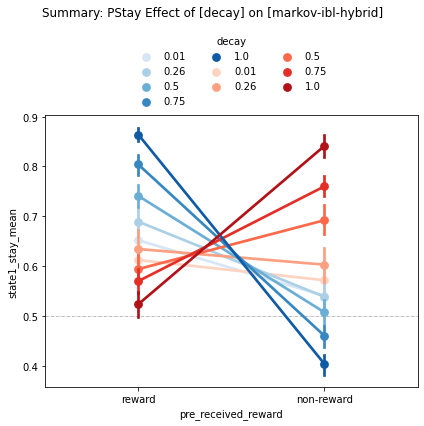

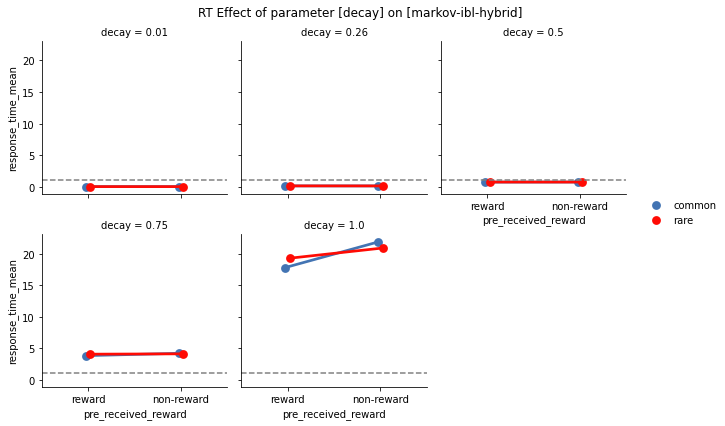

In [7]:
model_name = 'markov-ibl-hybrid'
param_name = 'decay'
df = MarkovSimulation.simulate_param_effect(model_name=model_name, param_name=param_name, save_output=dest_dir, e=50)
MarkovPlot.plot_param_effect(df=df, model_name=model_name, param_name=param_name, combination=True)
MarkovPlot.plot_param_effect_rt(df=df, model_name=model_name, param_name=param_name, combination=False)

### Effect of lf 

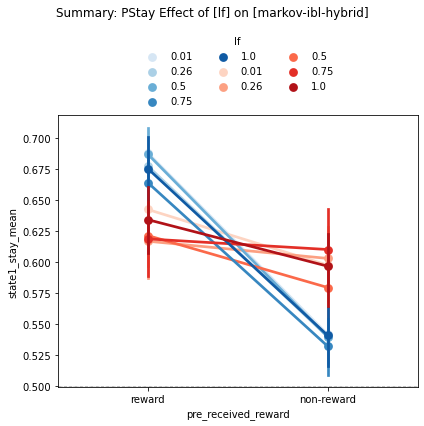

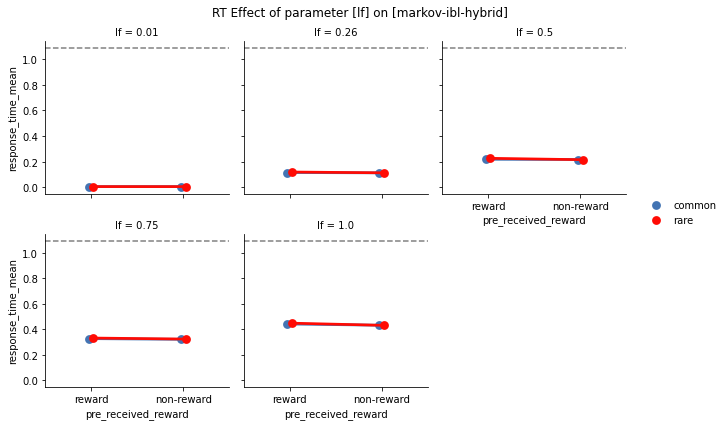

In [8]:
model_name = 'markov-ibl-hybrid'
param_name = 'lf'
df = MarkovSimulation.simulate_param_effect(model_name=model_name, param_name=param_name, save_output=dest_dir, e=50)
MarkovPlot.plot_param_effect(df=df, model_name=model_name, param_name=param_name, combination=True)
MarkovPlot.plot_param_effect_rt(df=df, model_name=model_name, param_name=param_name, combination=False)

### Effect of fixed_cost

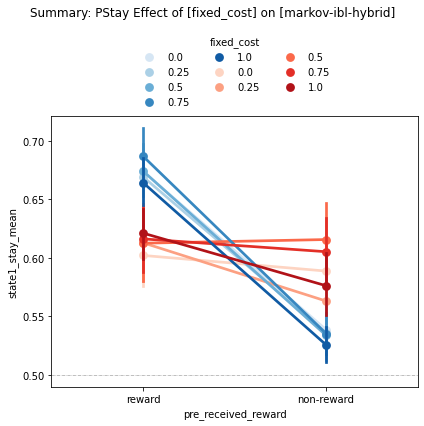

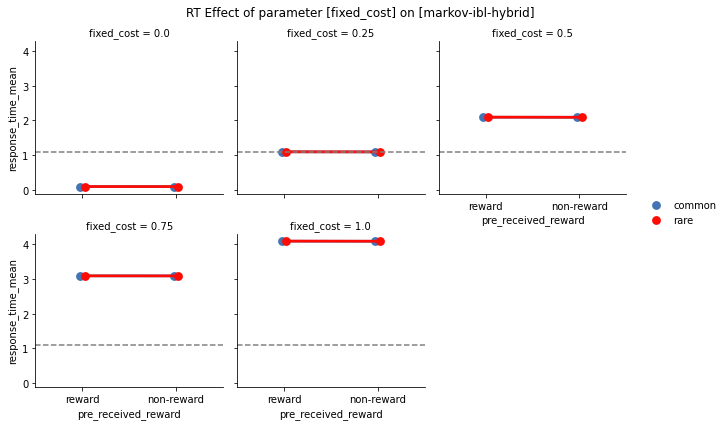

In [9]:
model_name = 'markov-ibl-hybrid'
param_name = 'fixed_cost'
df = MarkovSimulation.simulate_param_effect(model_name=model_name, param_name=param_name, save_output=dest_dir, e=50)
MarkovPlot.plot_param_effect(df=df, model_name=model_name, param_name=param_name, combination=True)
MarkovPlot.plot_param_effect_rt(df=df, model_name=model_name, param_name=param_name, combination=False)

## RL-MF Model

### Effect of temperature (noise)

We should not observe any effect of noise nor decay on RL-MF model

...LOAD...


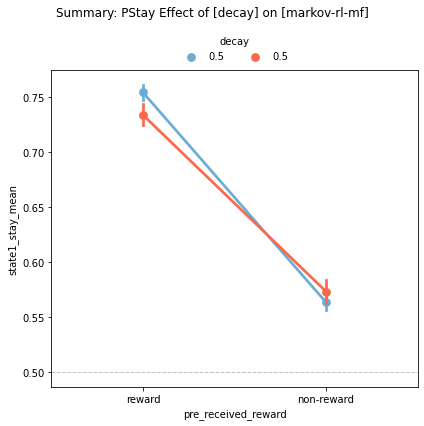

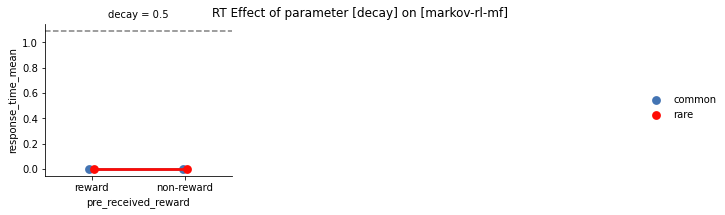

In [6]:
model_name = 'markov-rl-mf'
param_name = 'decay'
df = simulate_param_edf = MarkovSimulation.simulate_param_effect(model_name=model_name, param_name=param_name, save_output=dest_dir, e=50, overwrite=Fa dlse)
MarkovPlot.plot_param_effect(df=df, model_name=model_name, param_name=param_name, combination=True)
MarkovPlot.plot_param_effect_rt(df=df, model_name=model_name, param_name=param_name, combination=False)

## RL-MF Model

### Effect of alpha 


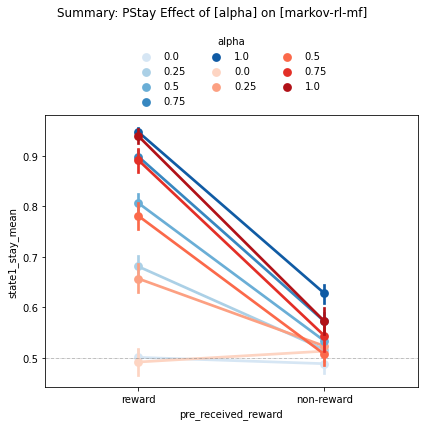

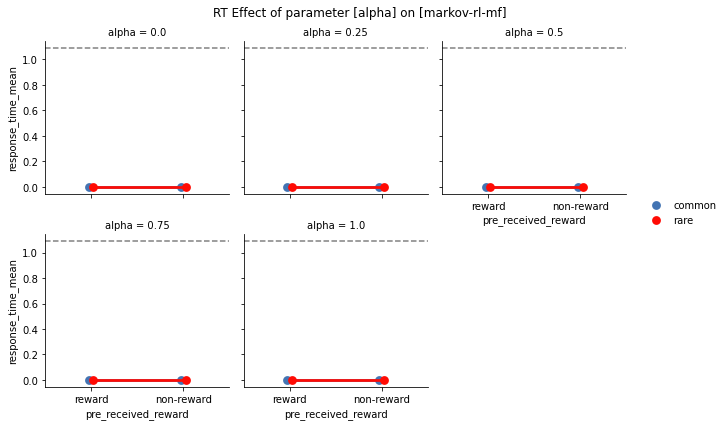

In [12]:
model_name = 'markov-rl-mf'
param_name = 'alpha'
df = MarkovSimulation.simulate_param_effect(model_name=model_name, param_name=param_name, save_output=dest_dir, e=50)
MarkovPlot.plot_param_effect(df=df, model_name=model_name, param_name=param_name, combination=True)
MarkovPlot.plot_param_effect_rt(df=df, model_name=model_name, param_name=param_name, combination=False)

### Effect of beta  

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

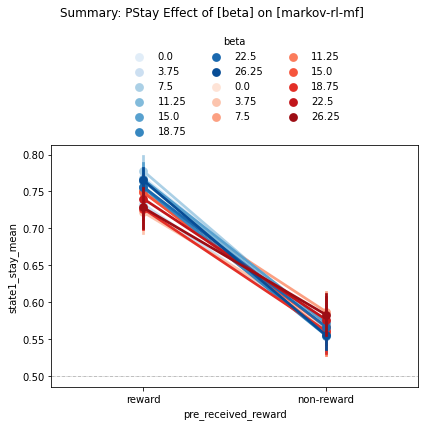

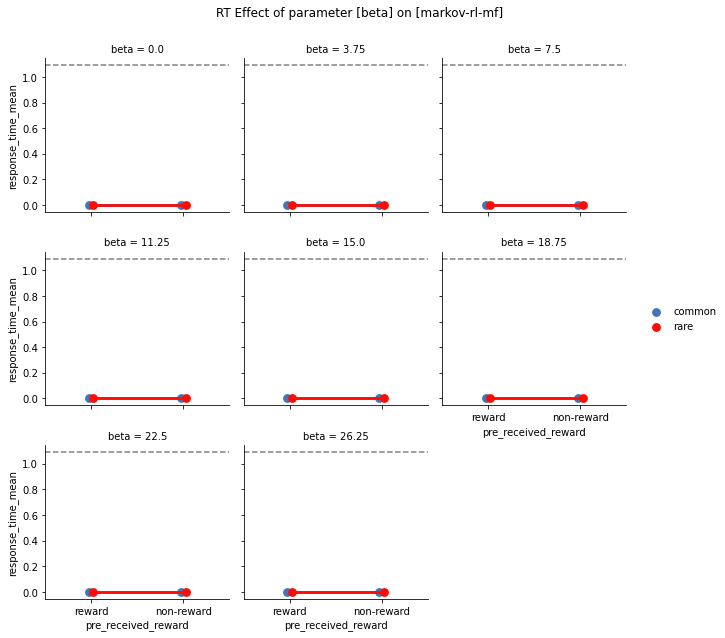

In [13]:
model_name = 'markov-rl-mf'
param_name = 'beta'
df = MarkovSimulation.simulate_param_effect(model_name=model_name, param_name=param_name, save_output=dest_dir, e=50)
MarkovPlot.plot_param_effect(df=df, model_name=model_name, param_name=param_name, combination=True)
MarkovPlot.plot_param_effect_rt(df=df, model_name=model_name, param_name=param_name, combination=False)

### Effect of beta_mf

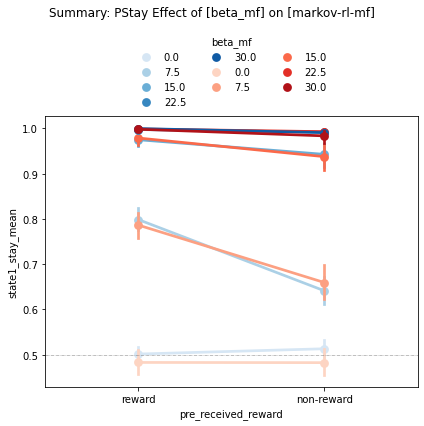

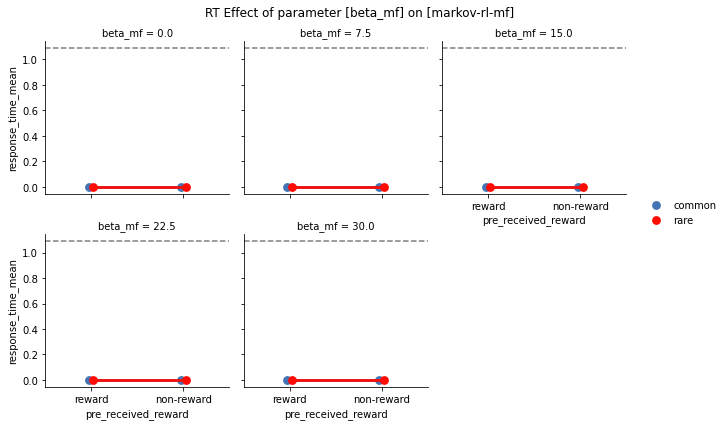

In [14]:
model_name = 'markov-rl-mf'
param_name = 'beta_mf'
df = MarkovSimulation.simulate_param_effect(model_name=model_name, param_name=param_name, save_output=dest_dir, e=50)
MarkovPlot.plot_param_effect(df=df, model_name=model_name, param_name=param_name, combination=True)
MarkovPlot.plot_param_effect_rt(df=df, model_name=model_name, param_name=param_name, combination=False)

### Effect of beta_mb

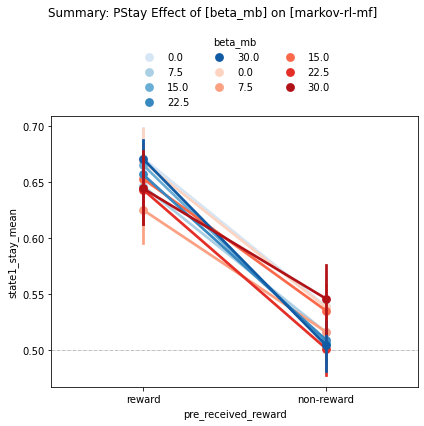

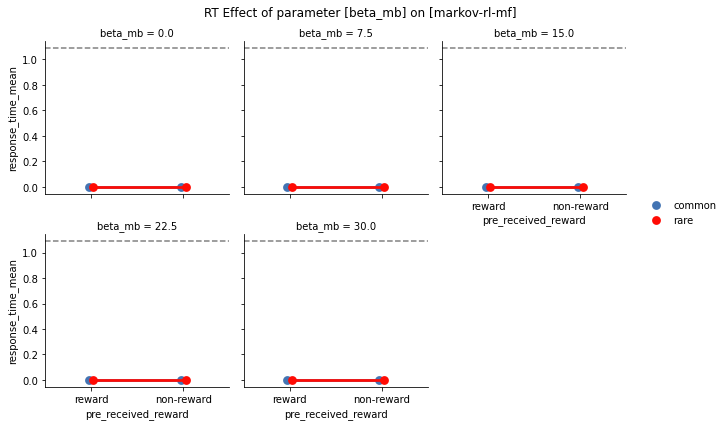

In [15]:
model_name = 'markov-rl-mf'
param_name = 'beta_mb'
df = MarkovSimulation.simulate_param_effect(model_name=model_name, param_name=param_name, save_output=dest_dir, e=50)
MarkovPlot.plot_param_effect(df=df, model_name=model_name, param_name=param_name, combination=True)
MarkovPlot.plot_param_effect_rt(df=df, model_name=model_name, param_name=param_name, combination=False)

## RL-MF Model

### Effect of lambda 


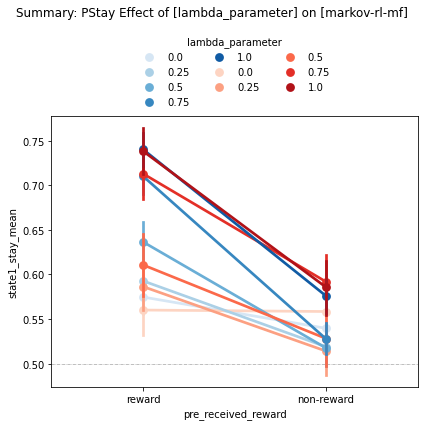

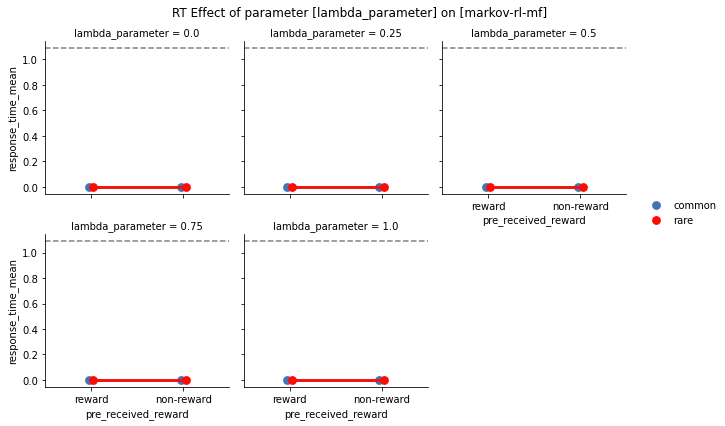

In [16]:
model_name = 'markov-rl-mf'
param_name = 'lambda_parameter'
df = MarkovSimulation.simulate_param_effect(model_name=model_name, param_name=param_name, save_output=dest_dir, e=50)
MarkovPlot.plot_param_effect(df=df, model_name=model_name, param_name=param_name, combination=True)
MarkovPlot.plot_param_effect_rt(df=df, model_name=model_name, param_name=param_name, combination=False)

## RL-MF Model

### Effect of stickness (p) 


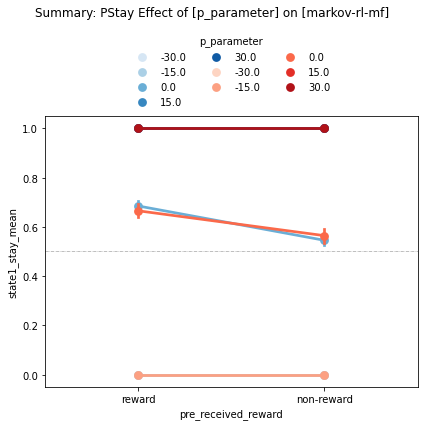

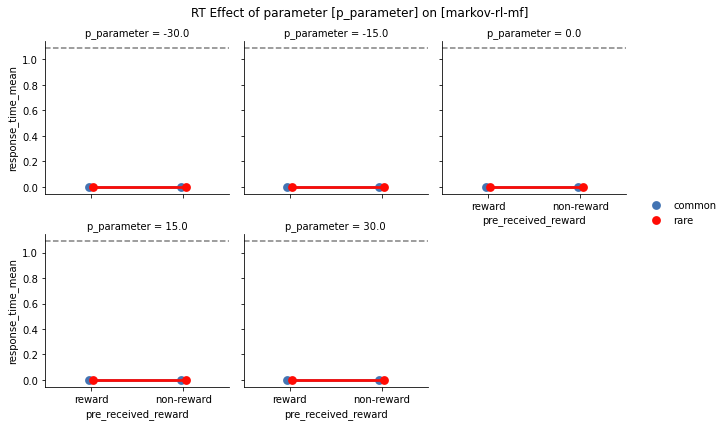

In [17]:
model_name = 'markov-rl-mf'
param_name = 'p_parameter'
df = MarkovSimulation.simulate_param_effect(model_name=model_name, param_name=param_name, save_output=dest_dir, e=50)
MarkovPlot.plot_param_effect(df=df, model_name=model_name, param_name=param_name, combination=True)
MarkovPlot.plot_param_effect_rt(df=df, model_name=model_name, param_name=param_name, combination=False)